# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.



**Цель проекта** - построить модель, которая по фотографии определит приблизительный возраст человека.


**Ход проекта:**

1. Исследовательский анализ данных
2. Обучение модели.
3. Анализ модели.
4. Общий итог.

В качестве модели воспользуемся предварительно обученную нейронную сеть - ResNet50.

В качестве метрики для задачи используется Mean Absolute Error (MAE). Результат будет удовлетворительным при значениее MAE < 8 лет.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

## Исследовательский анализ данных

In [2]:
# загрузка данных
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# с помощью загрузчика сформируем батчи с изображениями
datagen = ImageDataGenerator(rescale=1./255) 

gen_flow = datagen.flow_from_dataframe(dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим как выглядит таблица с данными.

In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные содержат 7591 фотографий. Чтобы понять хватит ли этих данных для обучения и настройки модели, построим график распределения возрастов. При неравномерном распределении данных может не хватить, что повлияет на качество модели. Чтобы решить проблему достаточно увеличить количество данных, изменяя оригинальные данные.

Таблица состоит из двух столбцов: название файла в формате .jpg и реальный возраст. В ней 7591 строк и 0 пропущенных значений.

Посмотрим на разброс возрастов и построим график распределения.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


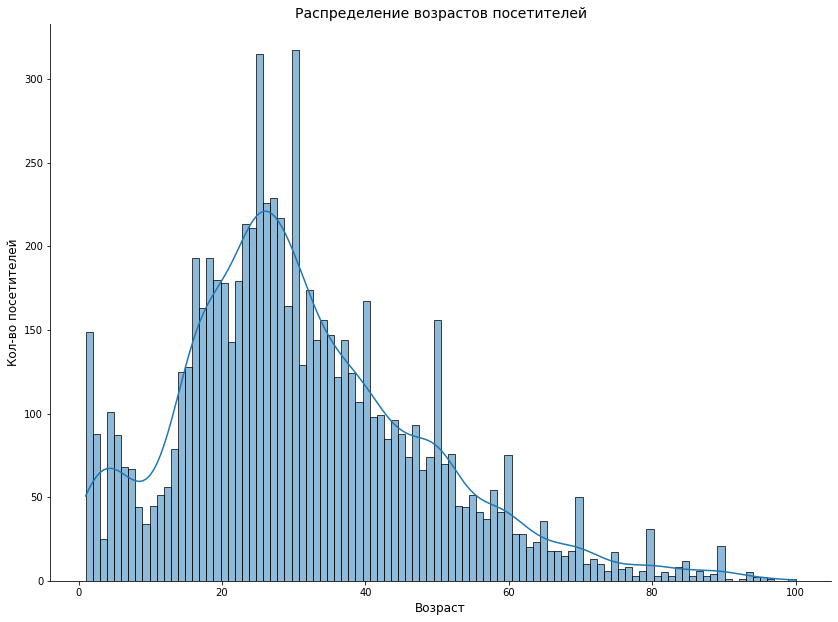

In [7]:
sns.displot(data, kde=True, height=8.27, aspect = 11.7/8.27, bins=100, legend=False);
plt.ylabel('Кол-во посетителей', fontsize=12);
plt.xlabel('Возраст', fontsize=12);
plt.title('Распределение возрастов посетителей', fontsize=14);

Как видно из распределения, оно неравномерное и  основная часть людей на фотографиях имеют возраст 20-35 лет. Модель будет чаще выбирать эти возраста при предугадывании возрастов. Чтобы улучшить качество модели необходимо увеличить количество данных с помощью следующих методов: фильтр ядра, геометрические преборазования фотографий, изменение масштабов и физические преобразования.

* средний возраст посетителей 31 год;
* минимальный и максимальный возраст: 1 и 100 лет соответственно;
* 75% данных занимают посетители до 41 года.

Посмотрим на фотографии из выборки.

In [9]:
X, y = next(gen_flow)

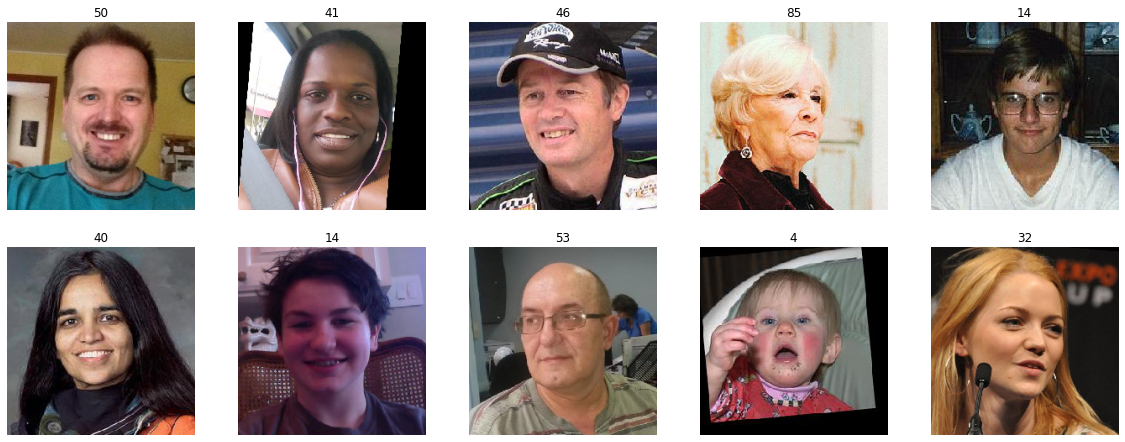

In [10]:
plt.figure(figsize=(20,20))

for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')

plt.show()

Как видно, фотографии заметно различаются:
* Черно-белые и цветные;
* С углом наклона фотографии;
* С углом наклона человека на фотографии;
* Со сдвигом фотографий;
* Различная яркость;
* Различые выражения лиц;
* Аксессуары и головные уборы

Все это повлияет на итоговый результат модели. Поэтому при настройке модели необходимо учесть эти особенности.

### Вывод

* Всего 7591 фотографий людей с возрастом от 1 года до 100 лет;
* Средний возраст посетителей - 31 год;
* Фотографии различаются по фону, яркости, смещению, углу поворота, цвету и т.д, поэтому при расширении данных добавим следующие параметры: `rotation_range`, `width_shift_range`, `height_shift_range`.

Перейдем к обучению модели

## Обучение модели

Код обучения модели:

```python



from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

def load_train(path):

    data = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=.25,
		rotation_range=20,
		width_shift_range=20,
		height_shift_range=20
		)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    data = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=.25)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Результаты обучения:**

```


Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 129s - loss: 239.0805 - mae: 11.3205 - val_loss: 748.9395 - val_mae: 22.4386
Epoch 2/6
178/178 - 95s - loss: 86.8921 - mae: 7.1443 - val_loss: 680.1589 - val_mae: 21.1027
Epoch 3/6
178/178 - 96s - loss: 62.3588 - mae: 6.0860 - val_loss: 415.2302 - val_mae: 15.5099
Epoch 4/6
178/178 - 97s - loss: 47.2957 - mae: 5.3077 - val_loss: 118.0504 - val_mae: 8.2165
Epoch 5/6
178/178 - 98s - loss: 39.6422 - mae: 4.8768 - val_loss: 109.7633 - val_mae: 8.0008
Epoch 6/6
178/178 - 98s - loss: 32.8270 - mae: 4.3931 - val_loss: 69.0811 - val_mae: 6.3147
60/60 - 10s - loss: 69.0811 - mae: 6.3147
Test MAE: 6.3147

```

### Вывод

Модель ResNet50 с заданными слоями и параметрами аугментации справилась с задачей с значением метрики `MAE` = 6.3

## Анализ обученной модели

В ходе проекта был проделаны следующие шаги:

1. Исследовательский анализ данных.
    * выявили средний возраст посетителей (31 год);
    * построили распределение их возрастов;
    * основная часть посетителей - люди до 40 лет;
    * фотографии довольно сильно различаются.
2. Обучение модели.
    * расширили объем данных с помощью ImageDataGEnerator из библиотеки keras
    * воспользовались сверточной нейронной сетью ResNet-50

В результате значение `MAE` на тестовой выборке составила `6.3` лет, что является удовлетворительным результатом. Модель готова к эксплуатации. 